# Plotting 2D Gradient Vector Field of Electrostatic Density 

## Introduction
This notebook is meant to visualize the 2 dimensional gradient vector field of the electronic density of the provided molecule

## Dependencies

1. [numpy](https://numpy.org/doc/stable/)
2. [matplotlib ](https://matplotlib.org/stable/contents.html)
3. [Chemtools](https://chemtools.org/usr_doc_installation.html) 

## Obtaining XYZ coordinates

We use the chemtools call `mol.coordinates` to obtain the XYZ cartesian coordinates of our molecule, in this example, dichloropyrimidine. 

In [20]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# mpl_toolkits.mplot3d import Axes3D

from chemtools import Molecule


mol = Molecule.from_file("dichloropyridine26_q+0.fchk")
coord = mol.coordinates

print("XYZ Coordinates: ")
print(coord)



Initialized: <horton.gbasis.cext.GOBasis object at 0x7fc93065f3d0>
  Number of basis functions         : 219
  Number of normalization constants : 453
  Maximum shell type                : 2
  Center     0 :  S9 S8 S8 S1 S1 P6 P6 P1 P1 Dp1 Dp1
  Center     1 :  S9 S8 S8 S1 S1 P6 P6 P1 P1 Dp1 Dp1
  Center     2 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     3 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     4 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     5 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     6 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     7 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     8 :  S3 S1 S1 P1 P1
  Center     9 :  S3 S1 S1 P1 P1
  Center    10 :  S3 S1 S1 P1 P1

XYZ Coordinates: 
[[-4.95130924e+00  2.31173977e+00 -2.64561659e-04]
 [ 4.95149821e+00  2.31139962e+00  2.07869875e-04]
 [ 7.55890453e-05  1.84250188e+00 -1.88972613e-05]
 [-9.44863066e-05 -3.41775868e+00  1.13383568e-04]
 [-2.28277027e+00 -2.09580077e+00 -1.88972613e-05]
 [ 2.28267578e+00 -2.09595195e+00  1.70075352e-0

## Rotate and Scale Operation

We wish to force the molecular to be planar, we accomplish this using numpy's linear algebra capabilities, more specifically rotation and scaling operations. 

First, we use `np.cross()` to perform a cross product and `np.linalg.norm()` on our coordinates to generate an orthonormal set. 

Then, we have to perform our rotation operation
```
cos(x)) + a^2 * (1-cos(x)      a*u*(1-cos(x)      u*sin(x)

a * u *(1-cos(x))           cos(x) + u^2 *(1-cos(x))   -a *sin(x)

-u * sin(x)                 a * sin(x)              cos(x) 
```



In [21]:
coord1 = coord[0] 
coord2 = coord[1]
coord3 = coord[2]

v1, v2 = coord2 - coord1, coord3 - coord1
normal = np.cross(v1, v2)
normal /= np.linalg.norm(normal)

a, b, c = normal
cos_theta = c
sin_theta = np.sqrt(a**2.0 + b**2.0)
u_1 = b / np.sqrt(a**2.0 + b**2.0)
u_2 = -a / np.sqrt(a**2.0 + b**2.0)
rot = np.array([
    [cos_theta + u_1**2.0 * (1 - cos_theta), u_1 * u_2 * (1 - cos_theta), u_2 * sin_theta],
    [u_1 * u_2 * (1 - cos_theta), cos_theta + u_2**2.0 * (1 - cos_theta), -u_1 * sin_theta],
    [-u_2 * sin_theta, u_1 * sin_theta, cos_theta]
])


## Plot our rotated coordinates

## Generate a Grid

To eventually plot our gradient vector field, we must initialize a "grid" with several points. Originally in 2D space, this will later be rotate back into 3D space

In [22]:
rot_coords = np.dot(rot, (coord - coord[0]).T).T


l_bnd = np.min(rot_coords, axis=0) - 1
u_bnd = np.max(rot_coords, axis=0) + 1
print(l_bnd)
step_size = 0.3
x_grid = np.arange(l_bnd[0], u_bnd[0] + step_size, step_size)
y_grid = np.arange(l_bnd[1], u_bnd[1] + step_size, step_size)
grid_2d = np.array(np.meshgrid(x_grid, y_grid)).T.reshape(-1,2)



[-11.15737795  -4.13120126  -1.00005684]


## Generating a Corresponding Affine Plane

We now must plot our coordinates on the grid plane generated below.

In [23]:
# Add zero z-axis and rotate it and translate it to the plane
grid_zeros = np.hstack((grid_2d, np.zeros((grid_2d.shape[0], 1), dtype=np.float)))
grid_plane = np.einsum("ij,kj->ki", rot.T, grid_zeros)
assert np.all(np.abs(np.dot(grid_plane, normal)) < 1e-5)
grid_plane += coord[0]


## Computing Gradient and Plotting  the Gradient Vector Field 

The gradient vector is a column vector of the partial derivative of each variable in a system. In the context of electron density of a molecule, the gradient vectors will become increasingly positive as one approaches individual atoms or functional groups that have a higher electrostatic potential, such as halogens or carboxylic acids.

### Computing

We use Chemtools `compute_gradient()` function on our input molecule and our previously generated grid plane to create our gradient vectors

We then to perform a projection, which is the dot product of the computed gradients and the orthonormal vectors subtracted from the computed gradient vectors.

### Plotting

We wish to visualize this in 2 dimensional cartesian space, which is accomplished by performing the dot product on our projection (`proj_gradients`) and our orthonormal vector. 



In [24]:
gradients = mol.compute_gradient(grid_plane)
print(gradients)

proj_gradients = gradients - np.dot(gradients, normal)[:, np.newaxis] * normal
# Make sure it is on the plane by making sure it is orthogonal to the normal.
assert np.all(np.dot(proj_gradients, normal) < 1e-5)
# Rotate the projected gradients onto two-dimensions.
rot_proj_gradients = np.dot(rot, proj_gradients.T).T
assert np.all(np.abs(rot_proj_gradients[:, 2]) < 1e-8)

[[ 1.70982687e-05  5.10868096e-04 -6.55691344e-09]
 [-2.04658254e-05  8.72965114e-04 -1.29942129e-08]
 [-1.34014657e-04  1.43885163e-03 -2.51374698e-08]
 ...
 [ 3.92944438e-08 -8.98940297e-06  1.84799988e-10]
 [ 3.01288771e-09 -6.67502749e-06  1.34390522e-10]
 [ 4.24791253e-09 -4.95304702e-06  9.83619427e-11]]


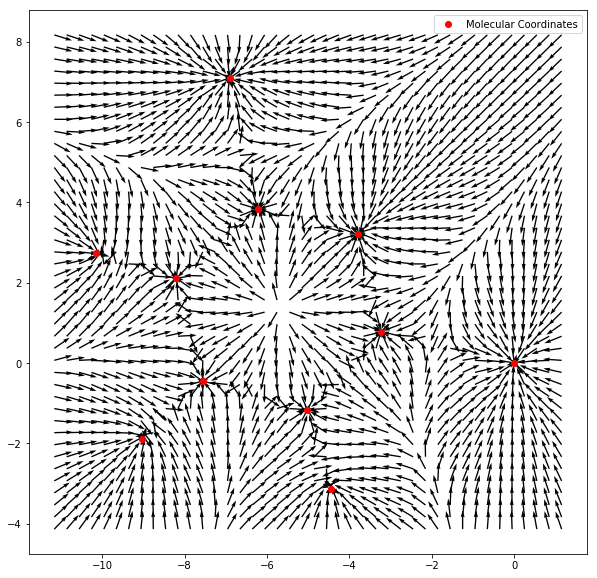

In [25]:
# Rotate Projected Plane.
rot_proj_gradients /= np.linalg.norm(rot_proj_gradients, axis=1).reshape((-1, 1))
plt.figure(figsize=(10,10))
plt.quiver(grid_2d[:, 0], grid_2d[:, 1],
         rot_proj_gradients[:, 0], rot_proj_gradients[:, 1],color='black', scale=30)
plt.plot(rot_coords[:, 0], rot_coords[:, 1], "ro", label="Molecular Coordinates")
plt.legend()
plt.show()

## Consolidation of Gradient Vector Plot into Function plotVectorFieldOverPlane()
The plotting of the gradient vector field has been consolidated into a function for ease of use and modularity 

In [3]:
def plotVectorFieldOverPlane(inFile,step_size=0.32, title=''):
    """
    This script will plot a vector quality of a molecule as a gradient plot
    
    Conda Environment
    -----------------
        This function must be executed in a conda environment containing: 
            chemtools
            
                link to configuring chemtools can be found here
                
                https://chemtools.org/usr_doc_installation.html
                
            Numpy
            MatPlotLib 
    
    Parameters
    -----------
    
    inFile : str
        This represents our input file.
        Our example is dichloropyridine26_q+0.fchk
    
    stepSize : float
        Step Size of 2D Affine Grid
        
    title : str
        Title of plot
    
    mol : chemtools object
            load inFile as chemtools Molecule module
            
    coord1 : np.ndarray()
        First point on plane 
        
    coord2 : np.ndarray() 
        Second Point on plane
    
    coord3 : np.ndarray() 
        Third Point on plane
    
    normal : np.cross()
        Orthonormalization of coordinates
        
    rot : np.array()
        Our rotation matrix
    
    rot_coords : np.dot()
        Pass our coordinates through the rotation matrix to rotate our affine plane
        
    grid_zeros : np.hstack()
        Populate our affine plane with zeros to then populate with our computer vector function
        
    vectorFunc : callabel() 
        Vector Field that inputs 3D point to 3D point 
        In this example, vectorFunc is mol.compute_gradient()
        
    color : str
        Color of Gradient Arrows  
    
    scale : int
        Scale of Gradient Arrows
        
    --------------
    End Parameters
    """
    
    
    mol = Molecule.from_file(inFile)
    coord = mol.coordinates
    coord1 = coord[0] 
    coord2 = coord[1]
    coord3 = coord[2]
    
    v1, v2 = coord2 - coord1, coord3 - coord1
    normal = np.cross(v1, v2)
    normal /= np.linalg.norm(normal)

    a, b, c = normal
    
      
    a,b,c = normal
    cos_theta = c
    sin_theta = np.sqrt(a**2.0 + b**2.0)
    u_1 = b / np.sqrt(a**2.0 + b**2.0)
    u_2 = -a / np.sqrt(a**2.0 + b**2.0)
    rot = np.array([
            
            [cos_theta + u_1**2.0 * (1 - cos_theta), u_1 * u_2 * (1 - cos_theta), u_2 * sin_theta],
            [u_1 * u_2 * (1 - cos_theta), cos_theta + u_2**2.0 * (1 - cos_theta), -u_1 * sin_theta],
            [-u_2 * sin_theta, u_1 * sin_theta, cos_theta]
            
        ])
    rot_coords = np.dot(rot, (coord - coord[0]).T).T


    l_bnd = np.min(rot_coords, axis=0) - 1
    u_bnd = np.max(rot_coords, axis=0) + 1
    print(l_bnd)
    
    x_grid = np.arange(l_bnd[0], u_bnd[0] + step_size, step_size)
    y_grid = np.arange(l_bnd[1], u_bnd[1] + step_size, step_size)
    grid_2d = np.array(np.meshgrid(x_grid, y_grid)).T.reshape(-1,2)

    # Add zero z-axis and rotate it and translate it to the plane
    grid_zeros = np.hstack((grid_2d, np.zeros((grid_2d.shape[0], 1), dtype=np.float)))
    grid_plane = np.einsum("ij,kj->ki", rot.T, grid_zeros)
    grid_plane += coord[0]
    
    vectorFunc = mol.compute_gradient(grid_plane)
    gradients = vectorFunc
    print(gradients)

    proj_gradients = gradients - np.dot(gradients, normal)[:, np.newaxis] * normal
    rot_proj_gradients = np.dot(rot, proj_gradients.T).T
    
    # Rotate Projected Plane.
    rot_proj_gradients /= np.linalg.norm(rot_proj_gradients, axis=1).reshape((-1, 1))
    
    #Visualize our plot 
    plt.figure(figsize=(10,10))
    plt.quiver(grid_2d[:, 0], grid_2d[:, 1],
         rot_proj_gradients[:, 0], rot_proj_gradients[:, 1],color='black', scale=45)
    plt.plot(rot_coords[:, 0], rot_coords[:, 1], "ro", label="Molecular Coordinates")
    plt.legend()
    
    plt.title(title)
    
   

Initialized: <horton.gbasis.cext.GOBasis object at 0x7faae56ead00>
  Number of basis functions         : 219
  Number of normalization constants : 453
  Maximum shell type                : 2
  Center     0 :  S9 S8 S8 S1 S1 P6 P6 P1 P1 Dp1 Dp1
  Center     1 :  S9 S8 S8 S1 S1 P6 P6 P1 P1 Dp1 Dp1
  Center     2 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     3 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     4 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     5 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     6 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     7 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     8 :  S3 S1 S1 P1 P1
  Center     9 :  S3 S1 S1 P1 P1
  Center    10 :  S3 S1 S1 P1 P1

[-11.15737795  -4.13120126  -1.00005684]
[[ 1.70982687e-05  5.10868096e-04 -6.55691344e-09]
 [-1.04931053e-05  7.99884048e-04 -1.16055706e-08]
 [-8.37508916e-05  1.22474323e-03 -2.02612834e-08]
 ...
 [ 3.37264489e-08 -9.01586420e-06  1.84176696e-10]
 [ 3.25398635e-09 -7.02805652e-06  1.41053402e-10]
 [ 2.07112074e-09 -5

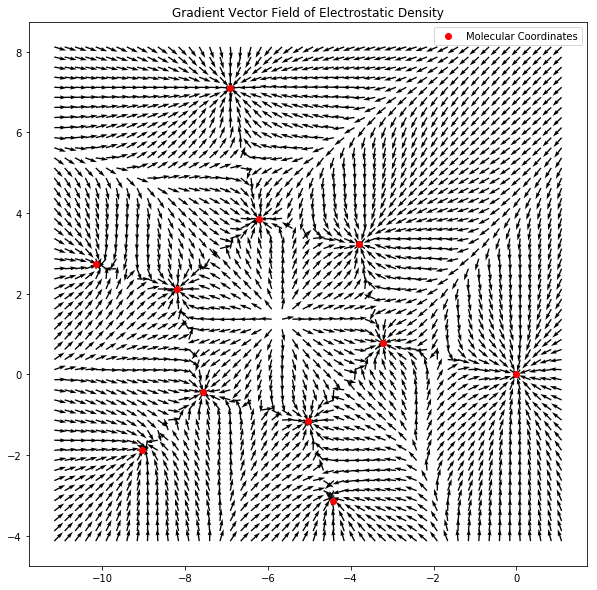

In [4]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# mpl_toolkits.mplot3d import Axes3D

from chemtools import Molecule

inFile = 'dichloropyridine26_q+0.fchk'

plotVectorFieldOverPlane(inFile,step_size=0.25, title='Gradient Vector Field of Electrostatic Density')

# Plotting Scalar Qualities of Molecules using Contour Plots

## Introduction

Scalar qualities, such as electron density, cannot be visualized as a gradient field. Instead, we can represent these qualities as level curves of a contour plot

## Rotation Matrix
Much like the previous function detailing the creating of a 3D rotation matrix to rotate our affine plane.

## Computing our Qualities Against the Affine Plane
In this example, we use `mol.compute_density()` to compute electron density against the affine plane. 


## Plotting our Scalar Values

Once rotated and computed, we can now initialize a figure and visualize our contour plot. 

In [5]:

def plotScalarFunctionContourPlot(inFile, step_size=0.3, title= 'Contour Plot'):
    """
    This script will plot a vector quality of a molecule as a gradient plot
    
    Conda Environment
    -----------------
        This function must be executed in a conda environment containing: 
            chemtools
            
                link to configuring chemtools can be found here
                
                https://chemtools.org/usr_doc_installation.html
                
            Numpy
            MatPlotLib 
    
    Parameters
    ----------
    
        inFile, str
            This represents our input Gaussian Checkpoint *.fchk file
        
        mol, chemtools object
            load inFile as chemtools Molecule module
                
        coord, chemtools API Call
            cartesian coordinates of inFile
            
        rot, np.array()
            Rotation Matrix used to rotate affine plane and normalize for plotting of scalarFunc
        
    """
    # Obtain Cartesian Coordinates
    mol = Molecule.from_file(inFile)
    coord = mol.coordinates
    coord1 = coord[0] 
    coord2 = coord[1]
    coord3 = coord[2]

    # Orthonormalization
    v1, v2 = coord1 - coord3, coord2 - coord3
    normal = np.cross(v1, v2)
    normal /= np.linalg.norm(normal)
    print("Orthonormal : ")
    a, b, c = normal
  
    # This represents our Rotate and Scale Operation,
    cos_theta = c
    sin_theta = np.sqrt(a**2.0 + b**2.0)
    u_1 = b / np.sqrt(a**2.0 + b**2.0)
    u_2 = -a / np.sqrt(a**2.0 + b**2.0)
    rot = np.array([
        [cos_theta + u_1**2.0 * (1 - cos_theta), u_1 * u_2 * (1 - cos_theta), u_2 * sin_theta],
        [u_1 * u_2 * (1 - cos_theta), cos_theta + u_2**2.0 * (1 - cos_theta), -u_1 * sin_theta],
        [-u_2 * sin_theta, u_1 * sin_theta, cos_theta]
    ])
    
    
    
    print("Rotation Operation: ")
    print(rot)

    rot_coords = np.dot(rot, (coord - coord[0]).T).T
    print("Rotation Coordinates: ")
    print(rot_coords)
    l_bnd = np.min(rot_coords, axis=0) - 1
    u_bnd = np.max(rot_coords, axis=0) + 1

    x_grid = np.arange(l_bnd[0], u_bnd[0] + step_size, step_size)
    y_grid = np.arange(l_bnd[1], u_bnd[1] + step_size, step_size)
    grid_2d = np.array(np.meshgrid(x_grid, y_grid)).T.reshape(-1,2)
    
    # fill grid space with zeros to later populate with scalarFunc
    grid_zeros = np.hstack((grid_2d, np.zeros((grid_2d.shape[0], 1), dtype=np.float)))
    grid_plane = np.einsum("ij,kj->ki", rot.T, grid_zeros)
    grid_plane += coord[0]
    print("Grid Plane:")
    print(grid_plane)

    # setup x,y for contour plot 
    x = grid_2d[:,0]
    y = grid_2d[:,1]
    xy = np.meshgrid(grid_2d[:,0],grid_2d[:,1])
    
    scalarFunc = mol.compute_density(grid_plane)

    # establish number of level curves
    levels = np.array([0.001 * n * n for n in range(1000)])
    
    # reshape level curves array to resemble length of x and y , with Fortran style iteration
    scalarFuncPlot = scalarFunc.reshape((len(x_grid), len(y_grid)), order="F")
    plt.figure(figsize=(10,10))
    plt.contour(x_grid,y_grid,scalarFuncPlot, levels )
    plt.title("Contour Plot of Electrostatic Density")

    plt.show()
    

Initialized: <horton.gbasis.cext.GOBasis object at 0x7faae56f8c20>
  Number of basis functions         : 219
  Number of normalization constants : 453
  Maximum shell type                : 2
  Center     0 :  S9 S8 S8 S1 S1 P6 P6 P1 P1 Dp1 Dp1
  Center     1 :  S9 S8 S8 S1 S1 P6 P6 P1 P1 Dp1 Dp1
  Center     2 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     3 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     4 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     5 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     6 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     7 :  S7 S7 S1 S1 P3 P1 P1 Dp1 Dp1
  Center     8 :  S3 S1 S1 P1 P1
  Center     9 :  S3 S1 S1 P1 P1
  Center    10 :  S3 S1 S1 P1 P1

Orthonormal : 
Rotation Operation: 
[[-6.97331320e-01  7.16748929e-01 -4.77061362e-05]
 [ 7.16748929e-01  6.97331321e-01  2.01453432e-05]
 [ 4.77061362e-05 -2.01453432e-05 -9.99999999e-01]]
Rotation Coordinates: 
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-6.90578162e+00  7.09758945e+00  1.38194199e-19]
 [-3.7

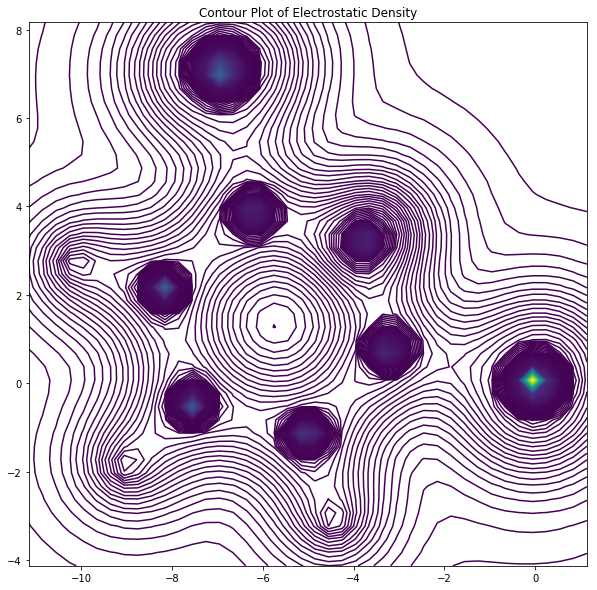

In [6]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from chemtools import Molecule

inFile = 'dichloropyridine26_q+0.fchk'


plotScalarFunctionContourPlot(inFile,step_size=0.3, title='Contour Plot' )